In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function



from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D, Dropout

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from datetime import datetime
from packaging import version

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
def append_extension(fn):
    return (fn+".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[:class_number-2] = 1
    return target


DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat([response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T], axis=1)
#shuffle dataset
response = response.sample(frac=1)


data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "training",
    shuffle=True,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw', 
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "validation",
    shuffle=True,
    batch_size = 28,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw',
)

# print(next(validation_set)[1].shape)

import tensorflow.keras.backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def soft_acc_multi_output(y_true, y_pred):
    return K.mean(K.all(K.equal(K.cast(K.round(y_true),'int32'), K.cast(K.round(y_pred),'int32')),axis=1))


# batch = next(validation_set)
# y_true = batch[1]
# y_pred = model.predict(batch[0])
# print(soft_acc_multi_output(y_true,y_pred))
# print(soft_acc_multi_output([[1, 1. ,0. ,0.]],[[7.6873720e-01, 2.9802322e-08 ,1.7881393e-07, 1.7881393e-07]]))

1 Physical GPUs, 1 Logical GPUs
Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [2]:
base_model = DenseNet121(include_top=False, weights="imagenet", classes=5, input_shape=(224,224,3))
base_model.trainable = False

In [3]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation="sigmoid")(x)
full_model = Model(inputs=base_model.input, outputs=preds, name = "multilogit_v1_")
full_model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output])
early_stopping = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 5, factor = 0.8)

history = full_model.fit_generator(generator=train_set,
                    epochs=25,
                    verbose=0,
                    validation_data=validation_set,
#                     validation_freq=2,
                    callbacks = [early_stopping, reduce_lr_plateau]
                    )

In [4]:
#################################
# fine tunes
#################################

In [6]:
full_model.trainable = True
for layer in full_model.layers[:70]:
    layer.trainable = False
for layer in full_model.layers[70:]:
    layer.trainable = True
    
validation_set.reset()
train_set.reset()
    
full_model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output])
logdir_name = r".\tfb\logs\densenet_multinomial_logit\\" + full_model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 5, factor = 0.5)


history_fine = full_model.fit_generator(generator=train_set,
                    epochs=100+history.epoch[-1],
#                     verbose=2,
                    validation_data=validation_set,
                    initial_epoch = history.epoch[-1],
                    callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
                    )

Epoch 11/110
16/16 [==============================] - 14s 897ms/step - loss: 0.4700 - soft_acc_multi_output: 0.3513 - val_loss: 2.8700 - val_soft_acc_multi_output: 0.1786
Epoch 12/110
16/16 [==============================] - 12s 739ms/step - loss: 0.3850 - soft_acc_multi_output: 0.4830 - val_loss: 6.7874 - val_soft_acc_multi_output: 0.1786
Epoch 13/110
16/16 [==============================] - 12s 751ms/step - loss: 0.3157 - soft_acc_multi_output: 0.5543 - val_loss: 3.5131 - val_soft_acc_multi_output: 0.1786
Epoch 14/110
16/16 [==============================] - 12s 758ms/step - loss: 0.2762 - soft_acc_multi_output: 0.5850 - val_loss: 4.9374 - val_soft_acc_multi_output: 0.1786
Epoch 15/110
16/16 [==============================] - 12s 748ms/step - loss: 0.2748 - soft_acc_multi_output: 0.6230 - val_loss: 1.6352 - val_soft_acc_multi_output: 0.3036
Epoch 16/110
16/16 [==============================] - 12s 746ms/step - loss: 0.2635 - soft_acc_multi_output: 0.6143 - val_loss: 2.4884 - val_soft

In [23]:
### city of overfit
########################################
# full_model.trainable = True
# for layer in full_model.layers[:-12]:
#     layer.trainable = False
# for layer in full_model.layers[-12:]:
#     layer.trainable = True
    
# validation_set.reset()
# train_set.reset()


# full_model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output])
# logdir_name = r".\tfb\logs\densenet_multinomial_logit\\" + full_model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
# early_stopping = EarlyStopping(monitor='val_loss', patience=21,restore_best_weights=True)
# reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.5)

# history_fine = full_model.fit_generator(generator=train_set,
#                     epochs=100+history_full_model.epoch[-1],
# #                     verbose=2,
#                     validation_data=validation_set,
#                     initial_epoch = history_full_model.epoch[-1],
#                     callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
#                     )

Epoch 25/124
16/16 [==============================] - 8s 506ms/step - loss: 0.5716 - soft_acc_multi_output: 0.2405 - val_loss: 0.7388 - val_soft_acc_multi_output: 0.1429
Epoch 26/124
16/16 [==============================] - 7s 451ms/step - loss: 0.4433 - soft_acc_multi_output: 0.3481 - val_loss: 1.3936 - val_soft_acc_multi_output: 0.1250
Epoch 27/124
16/16 [==============================] - 7s 458ms/step - loss: 0.4343 - soft_acc_multi_output: 0.3678 - val_loss: 1.7708 - val_soft_acc_multi_output: 0.1429
Epoch 28/124
16/16 [==============================] - 8s 470ms/step - loss: 0.3757 - soft_acc_multi_output: 0.4168 - val_loss: 1.7867 - val_soft_acc_multi_output: 0.1429
Epoch 29/124
16/16 [==============================] - 7s 455ms/step - loss: 0.3500 - soft_acc_multi_output: 0.4820 - val_loss: 2.6157 - val_soft_acc_multi_output: 0.1429
Epoch 30/124
16/16 [==============================] - 7s 460ms/step - loss: 0.3462 - soft_acc_multi_output: 0.4759 - val_loss: 3.0317 - val_soft_acc_m

In [ ]:
model.save(filepath ="./saved_models/my_multinomial/1/", save_format='h5')

In [ ]:
model = tf.keras.models.load_model(filepath ="./saved_models/my_effnet/1/",custom_objects={'soft_acc_multi_output':soft_acc_multi_output})

tf.Tensor(0.35714287, shape=(), dtype=float32)


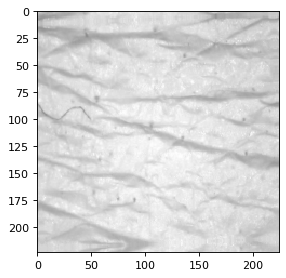

true label: [1 1 1 0]; rounded pred: [0.84732026 0.7366745  0.5729247  0.12707734]; Correct: True


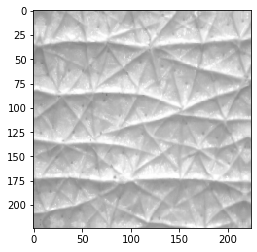

true label: [0 0 0 0]; rounded pred: [1.90734863e-06 0.00000000e+00 0.00000000e+00 1.06692314e-04]; Correct: True


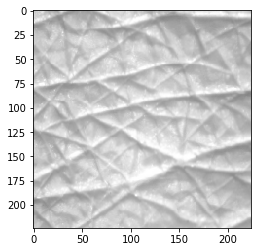

true label: [1 1 0 0]; rounded pred: [0.05419642 0.0079478  0.000231   0.02140859]; Correct: False


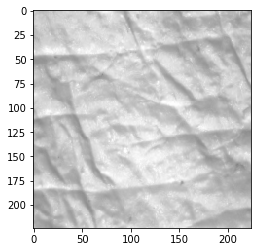

true label: [1 1 1 1]; rounded pred: [0.8348988  0.8070495  0.57414776 0.16291434]; Correct: False


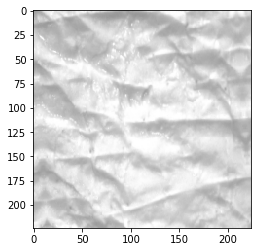

true label: [1 1 1 1]; rounded pred: [0.9633887  0.9982259  0.9992845  0.97504044]; Correct: True


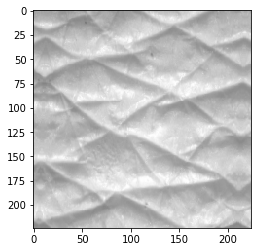

true label: [1 1 0 0]; rounded pred: [0.33620083 0.28679776 0.04305372 0.18981996]; Correct: False


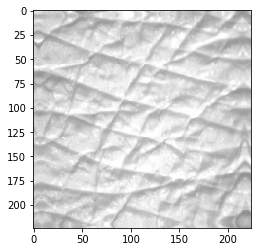

true label: [1 1 1 1]; rounded pred: [0.23012736 0.03594723 0.0040634  0.02782485]; Correct: False


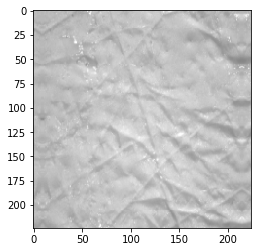

true label: [1 1 1 0]; rounded pred: [0.98354506 0.9998061  0.9999471  0.9955065 ]; Correct: False


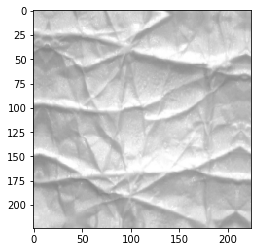

true label: [1 1 0 0]; rounded pred: [0.31052625 0.13318765 0.02066538 0.09202883]; Correct: False


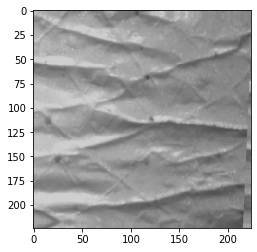

true label: [1 1 1 1]; rounded pred: [0.9363946  0.9531409  0.8984391  0.21492678]; Correct: False


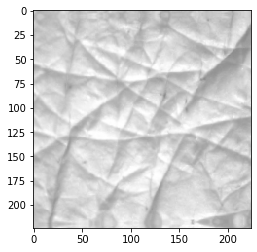

true label: [1 1 0 0]; rounded pred: [0.33119494 0.15923908 0.01218161 0.05143657]; Correct: False


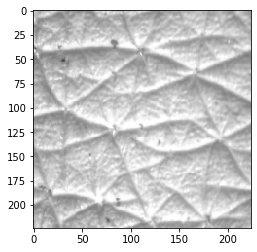

true label: [0 0 0 0]; rounded pred: [1.7255545e-05 5.9604645e-08 0.0000000e+00 9.1522932e-04]; Correct: True


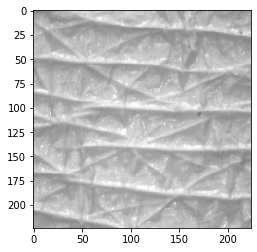

true label: [1 0 0 0]; rounded pred: [1.1646211e-02 1.1694431e-04 6.0200691e-06 3.0885041e-03]; Correct: False


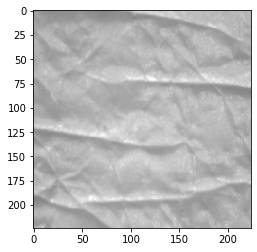

true label: [1 1 1 1]; rounded pred: [0.9719501  0.99885356 0.9995953  0.97855496]; Correct: True


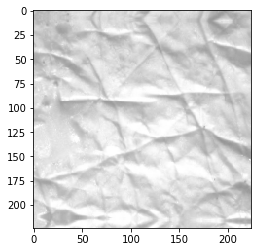

true label: [1 1 1 1]; rounded pred: [0.8459625 0.964785  0.8809004 0.6118617]; Correct: True


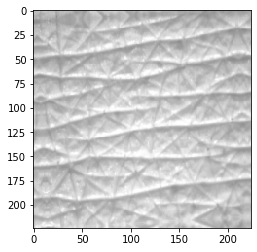

true label: [0 0 0 0]; rounded pred: [1.8590391e-03 1.0609627e-05 3.8743019e-07 3.7140548e-03]; Correct: True


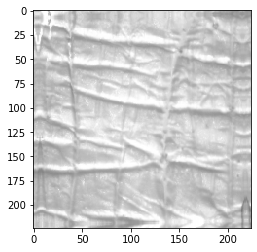

true label: [1 1 0 0]; rounded pred: [0.9306952  0.93374556 0.95044297 0.3956227 ]; Correct: False


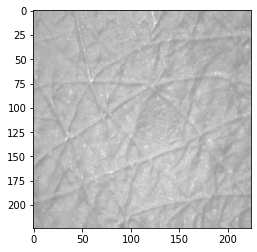

true label: [1 1 1 1]; rounded pred: [0.44692358 0.20331123 0.04606813 0.0824773 ]; Correct: False


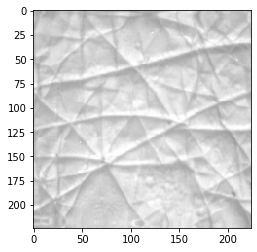

true label: [1 1 0 0]; rounded pred: [1.1299312e-02 4.6202540e-04 1.1742115e-05 9.4007254e-03]; Correct: False


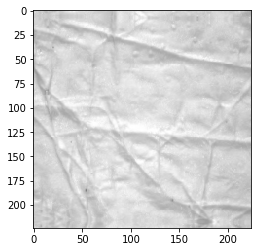

true label: [1 1 1 1]; rounded pred: [0.9134659  0.9886343  0.98246276 0.8313828 ]; Correct: True


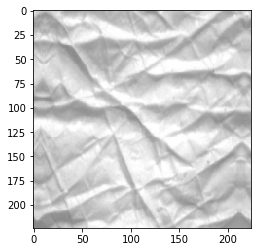

true label: [1 1 1 1]; rounded pred: [0.55758166 0.7583562  0.42669097 0.5625129 ]; Correct: False


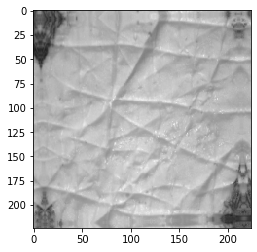

true label: [1 1 0 0]; rounded pred: [0.5572801  0.19168442 0.02168611 0.0179348 ]; Correct: False


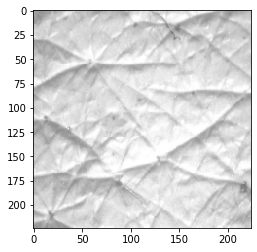

true label: [1 1 0 0]; rounded pred: [0.37148976 0.11852545 0.00730178 0.0206514 ]; Correct: False


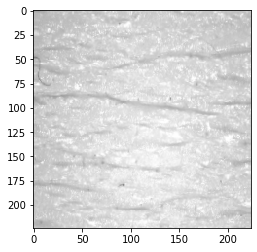

true label: [1 1 1 1]; rounded pred: [0.99774396 0.99938166 0.9999504  0.80429286]; Correct: True


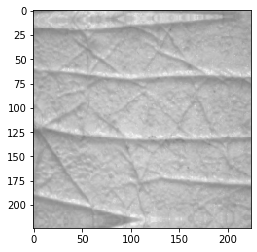

true label: [1 1 1 0]; rounded pred: [0.80529517 0.11522815 0.09099567 0.00747266]; Correct: False


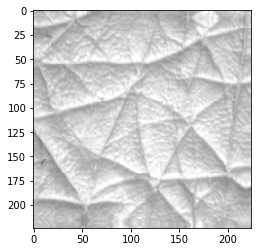

true label: [0 0 0 0]; rounded pred: [1.6339719e-03 1.9609928e-05 4.7683716e-07 5.5426955e-03]; Correct: True


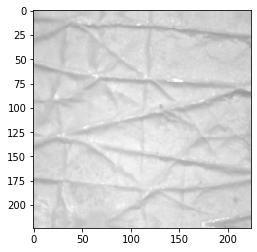

true label: [1 1 0 0]; rounded pred: [0.35544366 0.01576495 0.00100273 0.00166953]; Correct: False


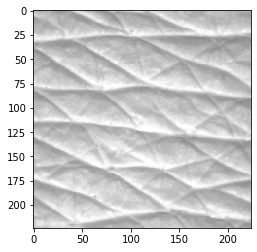

true label: [1 0 0 0]; rounded pred: [2.8296202e-02 9.5885992e-04 4.4733286e-05 7.9964101e-03]; Correct: False


In [27]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = full_model.predict(batch[0])
print(soft_acc_multi_output(y_true,y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {K.all(K.equal(K.cast(K.round(label),'int32'), K.cast(K.round(y_pred[i]),'int32')))}")